In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
"""

This pipeline performs:

1. Data Loading
2. Data Cleaning
3. Feature Engineering
4. Encoding and Scaling
5. Exploratory Data Analysis (EDA)

IMPORTANT:
Weekday feature is created ONLY if valid datetime exists.
This prevents incorrect analysis when time format is MM:SS only.
"""



class BikeSharePipeline():
    
    def __init__(self, file_path):
        """
        Initialize pipeline with dataset path.

        Parameters:
        file_path (str): Path to CSV dataset
        """

        self.file_path = file_path
        
        # Original raw dataset
        self.df = None
        
        # Final processed dataset
        self.df_processed = None


    def __str__(self):
        """
        Print dataset summary when object is printed.
        """

        if self.df is None:
            return "Dataset not loaded."

        return (
            f"\nBikeSharePipeline Dataset Summary\n"
            f"Rows: {self.df.shape[0]}\n"
            f"Columns: {self.df.shape[1]}\n"
        )


    def summary(self):
        """
        Show full dataset overview.
        """

        if self.df is None:
            print("Dataset not loaded.")
            return

        print("\nHEAD:")
        print(self.df.head())

        print("\nINFO:")
        print(self.df.info())

        print("\nDESCRIBE:")
        print(self.df.describe())

        print("\nMISSING VALUES:")
        print(self.df.isnull().sum())


    def load_data(self):
        """
        Load dataset from CSV file.
        """

        self.df = pd.read_csv(self.file_path)

        print(f"Data loaded successfully: {self.df.shape}")

        return self


    def clean_data(self):
        """
        Clean dataset and fix data quality issues.

        Steps:
        - Remove missing station data
        - Fill missing gender
        - Remove missing birth year
        - Convert IDs to int
        - Convert categorical columns
        - Create age column
        - Remove duplicates
        - Remove outliers using IQR
        """

        # Remove rows missing critical station info
        self.df.dropna(
            subset=[
                'start_station_id',
                'start_station_name',
                'end_station_id',
                'end_station_name'
            ],
            inplace=True
        )


        # Fill missing gender
        mode_gender = self.df['member_gender'].mode()[0]

        self.df['member_gender'].fillna(
            mode_gender,
            inplace=True
        )


        # Remove missing birth year
        self.df.dropna(
            subset=['member_birth_year'],
            inplace=True
        )


        # Convert IDs to integer
        self.df['start_station_id'] = self.df['start_station_id'].astype(int)
        self.df['end_station_id'] = self.df['end_station_id'].astype(int)


        # Convert categorical columns
        categorical_cols = [
            'start_station_name',
            'end_station_name',
            'user_type',
            'member_gender',
            'bike_share_for_all_trip'
        ]

        for col in categorical_cols:
            self.df[col] = self.df[col].astype('category')


        # Create age feature
        self.df['age'] = 2019 - self.df['member_birth_year']


        # Remove duplicates
        self.df.drop_duplicates(inplace=True)


        # Remove duration outliers using IQR
        Q1 = self.df['duration_sec'].quantile(0.25)
        Q3 = self.df['duration_sec'].quantile(0.75)

        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        self.df = self.df[
            (self.df['duration_sec'] >= lower) &
            (self.df['duration_sec'] <= upper)
        ]


        print(f"After cleaning: {self.df.shape}")

        return self


    def engineer_features(self):
        """
        Create useful ML features.

        Features:
        - duration_min
        - age_group
        - weekday (ONLY if valid datetime exists)
        """

        # Duration in minutes
        self.df['duration_min'] = self.df['duration_sec'] / 60


        # Try extracting weekday safely
        self.df['start_time_dt'] = pd.to_datetime(
            self.df['start_time'],
            errors='coerce'
        )

        if self.df['start_time_dt'].notna().sum() > 0:

            self.df['weekday'] = self.df['start_time_dt'].dt.day_name()

            print("Weekday feature created successfully.")

        else:

            print("Weekday feature NOT created (invalid time format).")


        # Age groups
        self.df['age_group'] = pd.cut(

            self.df['age'],

            bins=[18, 30, 45, 60, 100],

            labels=[
                'Young Adult',
                'Adult',
                'Middle Aged',
                'Senior'
            ],

            right=False
        )


        return self


    def encode_and_scale(self):
        """
        Encode categorical variables and scale numeric features.
        """

        # One-hot encoding
        self.df_processed = pd.get_dummies(

            self.df,

            columns=[
                'user_type',
                'member_gender',
                'bike_share_for_all_trip'
            ],

            drop_first=True
        )


        # Min-Max Scaling
        scale_cols = ['duration_min', 'age']

        for col in scale_cols:

            min_val = self.df_processed[col].min()
            max_val = self.df_processed[col].max()

            self.df_processed[col] = (

                self.df_processed[col] - min_val

            ) / (max_val - min_val)


        return self


    def plot_eda(self):
        """
        Generate full EDA visualizations.

        Includes:
        - Trip duration distribution
        - User type distribution
        - Age group distribution
        - Top stations
        - Trips by weekday (if available)
        """

        sns.set_style("whitegrid")


        # Duration Distribution
        plt.figure(figsize=(10,6))

        sns.histplot(
            self.df['duration_min'],
            bins=50,
            kde=True
        )

        plt.title("Trip Duration Distribution")
        plt.show()



        # User Type Distribution
        plt.figure(figsize=(8,6))

        self.df['user_type'].value_counts().plot(
            kind='pie',
            autopct='%1.1f%%'
        )

        plt.title("User Type Distribution")
        plt.ylabel("")
        plt.show()



        # Age Group Distribution
        plt.figure(figsize=(10,6))

        age_order = [
            'Young Adult',
            'Adult',
            'Middle Aged',
            'Senior'
        ]

        sns.countplot(

            data=self.df,

            x='age_group',

            hue='user_type',

            order=age_order
        )

        plt.title("Age Group vs User Type")
        plt.show()

        # Weekday Plot (SAFE)
        if 'weekday' in self.df.columns:

            plt.figure(figsize=(10,6))

            weekday_order = [
                'Monday','Tuesday','Wednesday',
                'Thursday','Friday','Saturday','Sunday'
            ]

            sns.countplot(
                data=self.df,
                x='weekday',
                order=weekday_order
            )

            plt.title("Trips by Weekday")
            plt.xticks(rotation=30)
            plt.show()

        else:

            print("Weekday plot skipped (no valid datetime).")





Data loaded successfully: (183416, 16)

BikeSharePipeline Dataset Summary
Rows: 183416
Columns: 16



C:\Users\Test\AppData\Local\Temp\ipykernel_14548\2546896274.py:116: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  self.df['member_gender'].fillna(


After cleaning: (165624, 17)


C:\Users\Test\AppData\Local\Temp\ipykernel_14548\2546896274.py:190: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df['start_time_dt'] = pd.to_datetime(


Weekday feature created successfully.

Processed Dataset Info:
<class 'pandas.DataFrame'>
Index: 165624 entries, 6 to 183411
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   duration_sec                 165624 non-null  int64         
 1   start_time                   165624 non-null  str           
 2   end_time                     165624 non-null  str           
 3   start_station_id             165624 non-null  int64         
 4   start_station_name           165624 non-null  category      
 5   start_station_latitude       165624 non-null  float64       
 6   start_station_longitude      165624 non-null  float64       
 7   end_station_id               165624 non-null  int64         
 8   end_station_name             165624 non-null  category      
 9   end_station_latitude         165624 non-null  float64       
 10  end_station_longitude        165624 non-null 

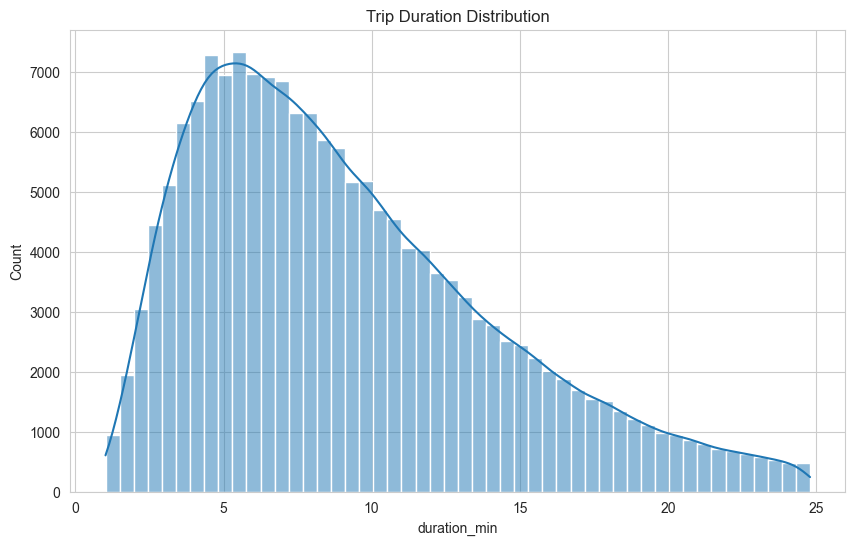

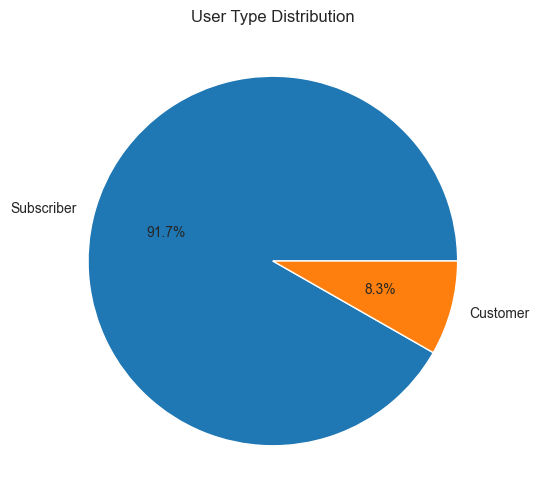

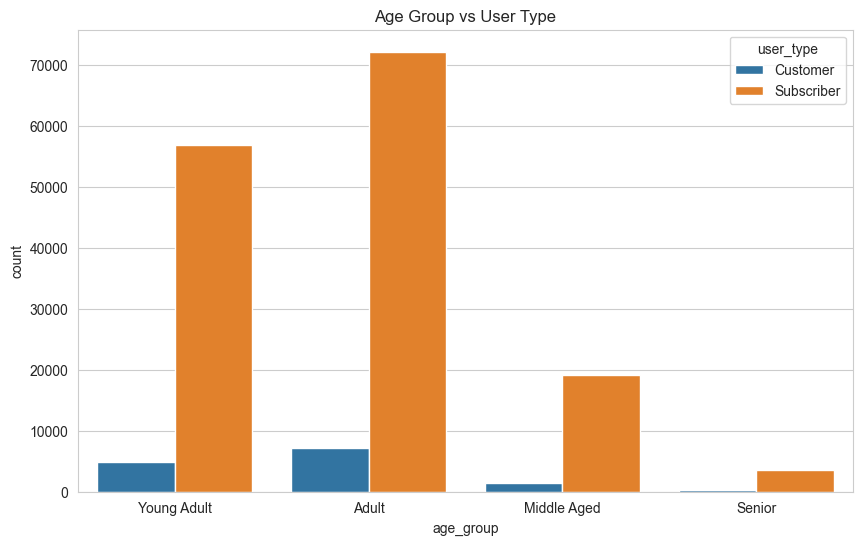

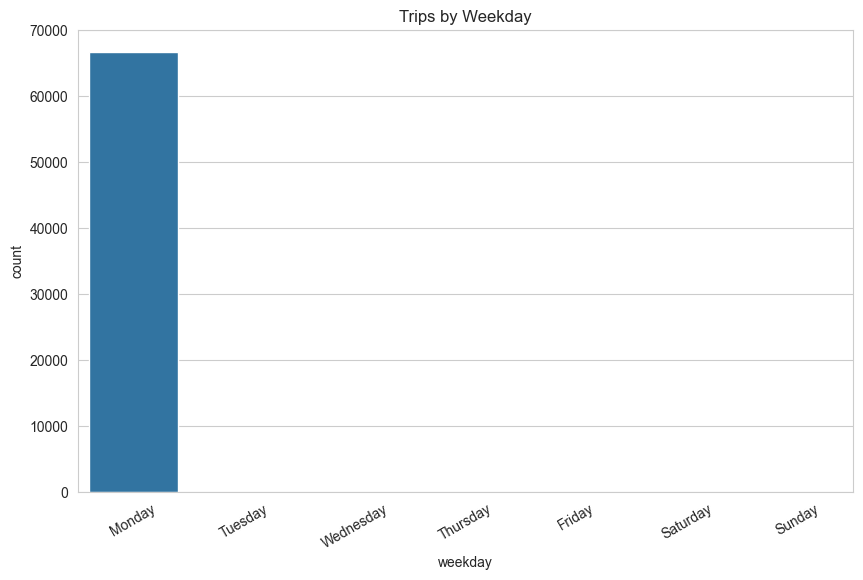


Pipeline executed successfully.


In [3]:
def main():

    file_path = "fordgobike-tripdataFor201902.csv"

    pipeline = BikeSharePipeline(file_path)

    pipeline.load_data()

    print(pipeline)

    pipeline.clean_data()

    pipeline.engineer_features()

    pipeline.encode_and_scale()

    print("\nProcessed Dataset Info:")
    print(pipeline.df_processed.info())

    pipeline.plot_eda()

    print("\nPipeline executed successfully.")



if __name__ == "__main__":
    main()
